# Regression and DNN Model 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pydot

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import KFold

print(tf.__version__)

2.4.1


# Get Dataset

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Check Null values

In [4]:
#The dataset contains a few unknown values.
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
#Drop those rows to keep this initial tutorial simple.
dataset = dataset.dropna()

## Data Adjusting 

In [6]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


# Splitting Data to training and testing data

In [7]:
#train_dataset = dataset.sample(frac=0.8, random_state=0)

#test_dataset = dataset.drop(train_dataset.index)



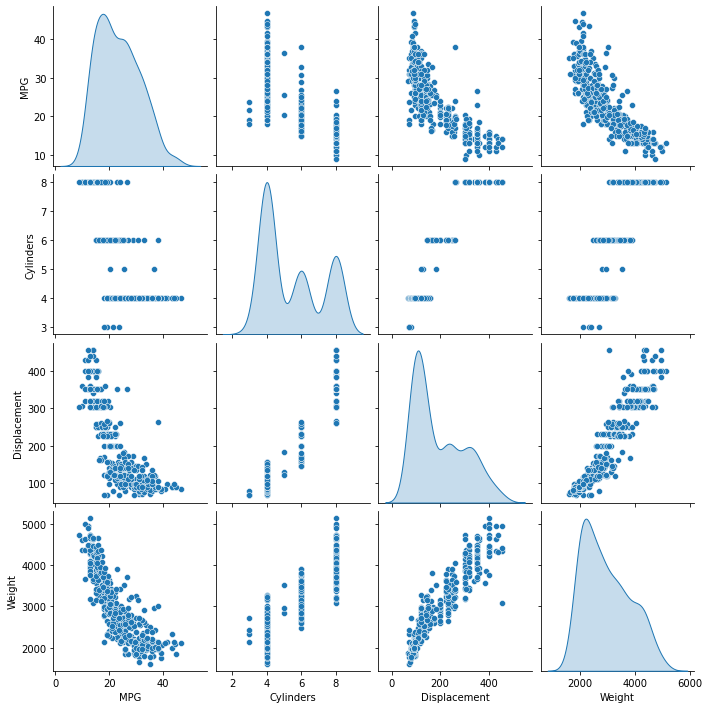

In [8]:
sns.pairplot(dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [9]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0


#Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.
train_features = train_dataset.copy()
test_features = test_dataset.copy()


train_labels_0 = train_features[['MPG']].copy()
train_labels_1 = train_features[['Weight']].copy()

train_features = train_features.drop(['MPG','Weight'], axis=1)

test_labels_0 = test_features[['MPG']].copy()
test_labels_1 = test_features[['Weight']].copy()

test_features = test_features.drop(['MPG','Cylinders'], axis=1)

acc_per_fold = []
loss_per_fold = []

print(train_features.shape)



#In the table of statistics it's easy to see how different the ranges of each feature are.
train_dataset.describe().transpose()[['mean', 'std']]

# Data Normalization



normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

print(type(normalizer))


first = np.array(train_features[:1])
tx = np.array(train_features)


with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

In [10]:
acc_per_fold = []
loss_per_fold = []

# Keras Functional API Model


In [11]:


def build_and_compile_model_0(norm):
    inputs = keras.Input(shape=(8,))

    dense = layers.Dense(64, activation="relu")
    x = dense(inputs)
    
    x = layers.Dense(64, activation="relu")(x)
    y = layers.Dense(64, activation="relu")(x)
    z = layers.Dense(64, activation="relu")(x)
    output_mph = layers.Dense(1)(y)
    output_cyl = layers.Dense(1)(z)


    model = keras.Model(inputs=inputs, outputs=[output_mph,output_cyl])
    model.compile(loss=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.001),metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.Accuracy(name='accuracy', dtype=None)]
    )
    return model

In [13]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(dataset):
    
    train_features = dataset.reindex(train)
    test_features = dataset.reindex(test)

    train_features = train_features.dropna()
    test_features = test_features.dropna()


    train_labels_0 = train_features[['MPG']].copy()
    train_labels_1 = train_features[['Weight']].copy()

    train_features = train_features.drop(['MPG','Weight'], axis=1)

    test_labels_0 = test_features[['MPG']].copy()
    test_labels_1 = test_features[['Weight']].copy()

    test_features = test_features.drop(['MPG','Cylinders'], axis=1)

    normalizer = preprocessing.Normalization()

    normalizer.adapt(np.array(train_features))

    dnn_model = build_and_compile_model_0(normalizer)
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = dnn_model.fit(train_features, y= (train_labels_0,train_labels_1), batch_size=64, epochs=100, validation_split=0.1)

    # Generate generalization metrics
    
    scores = dnn_model.evaluate(test_features, (test_labels_0, test_labels_1), verbose=0)
    print(f'Score for fold {fold_no}: {dnn_model.metrics_names[0]} of {scores[0]}; {dnn_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

bsolute_error: 3055.9167 - dense_77_accuracy: 0.0000e+00 - val_loss: 2.8175 - val_dense_76_loss: 2.8175 - val_dense_76_mean_absolute_error: 2.8175 - val_dense_76_accuracy: 0.0000e+00 - val_dense_77_mean_absolute_error: 2906.9209 - val_dense_77_accuracy: 0.0000e+00
Epoch 58/100
5/5 [==============================] - 0s 15ms/step - loss: 1.6876 - dense_76_loss: 1.6876 - dense_76_mean_absolute_error: 1.6876 - dense_76_accuracy: 0.0000e+00 - dense_77_mean_absolute_error: 3089.7470 - dense_77_accuracy: 0.0000e+00 - val_loss: 3.0576 - val_dense_76_loss: 3.0576 - val_dense_76_mean_absolute_error: 3.0576 - val_dense_76_accuracy: 0.0000e+00 - val_dense_77_mean_absolute_error: 2907.0146 - val_dense_77_accuracy: 0.0000e+00
Epoch 59/100
5/5 [==============================] - 0s 16ms/step - loss: 1.5730 - dense_76_loss: 1.5730 - dense_76_mean_absolute_error: 1.5730 - dense_76_accuracy: 0.0000e+00 - dense_77_mean_absolute_error: 3087.4456 - dense_77_accuracy: 0.0000e+00 - val_loss: 2.8592 - val_dens

# Define the K-fold Cross Validator
kfold = KFold(n_splits=20, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(train_features, train_labels_0, train_labels_1):
    
    def build_and_compile_model_0(norm):
        inputs = keras.Input(shape=(8,))

        dense = layers.Dense(100, activation="relu")
        x = dense(inputs)
    
        x = layers.Dense(100, activation="relu")(x)
        y = layers.Dense(100, activation="relu")(x)
        z = layers.Dense(64, activation="relu")(x)
        output_mph = layers.Dense(1)(y)
        output_cyl = layers.Dense(1)(z)


        model = keras.Model(inputs=inputs, outputs=[output_mph,output_cyl])
        model.compile(loss=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.001),metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.Accuracy(name='accuracy', dtype=None)])
        return model
    dnn_model = build_and_compile_model_0(normalizer)
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = dnn_model.fit(train_features, y= (train_labels_0,train_labels_1), batch_size=64, epochs=60, validation_split=0.1)
    # Generate generalization metrics
    
    scores = dnn_model.evaluate(test_features, (test_labels_0, test_labels_1), verbose=0)
    print(f'Score for fold {fold_no}: {dnn_model.metrics_names[0]} of {scores[0]}; {dnn_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 64)           576         input_5[0][0]                    
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 64)           4160        dense_24[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 64)           4160        dense_25[0][0]                   
____________________________________________________________________________________________

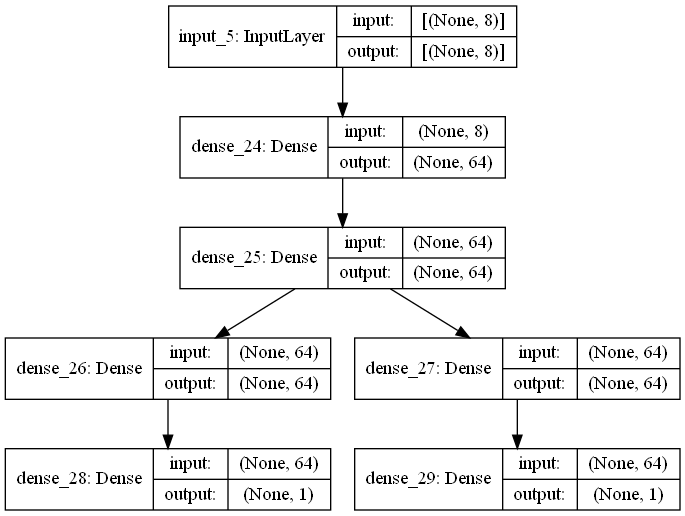

In [25]:
dnn_model.summary()
keras.utils.plot_model(dnn_model, "multi_input_and_output_model.png", show_shapes=True)


# Model Evaluation

In [14]:

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 38.16368103027344 - Accuracy: 3816.3681030273438%
------------------------------------------------------------------------
> Fold 2 - Loss: 347.958984375 - Accuracy: 34795.8984375%
------------------------------------------------------------------------
> Fold 3 - Loss: 332.89373779296875 - Accuracy: 33289.373779296875%
------------------------------------------------------------------------
> Fold 4 - Loss: 170.91961669921875 - Accuracy: 17091.961669921875%
------------------------------------------------------------------------
> Fold 5 - Loss: 467.8177795410156 - Accuracy: 46781.77795410156%
------------------------------------------------------------------------
> Fold 6 - Loss: 56.1678466796875 - Accuracy: 5616.78466796875%
------------------------------------------------------------------------
> Fold 7 -

None


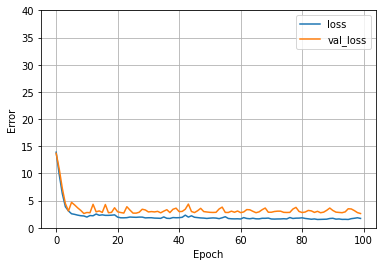

In [15]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 40])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
print(plot_loss(history))

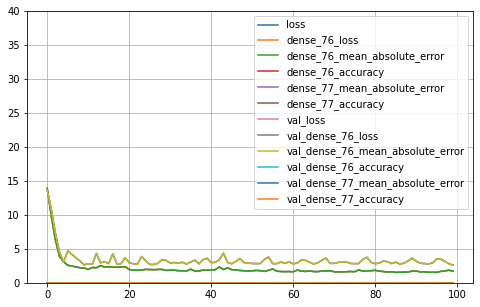

In [16]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 40) 
plt.show()

In [17]:
dnn_model.evaluate(test_features, y=(test_labels_0,test_labels_1), verbose=0)

[214.31150817871094,
 214.31150817871094,
 214.31150817871094,
 0.0,
 2262.7783203125,
 0.0]

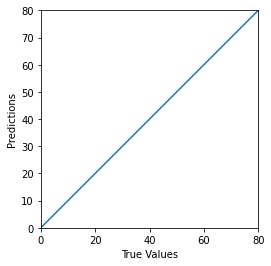

In [19]:
test_predictions = dnn_model.predict(test_features)

a = plt.axes(aspect='equal')
plt.scatter(test_labels_0, test_predictions[0])
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0,80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [31]:
np.random.__RandomState_ctor

<function numpy.random.__RandomState_ctor()>